# Depth Map Prediction from a Single Image using UNET architecture


# NYU Depth V2 dataset

In [ ]:
# Import Libraries

# System
import os
import gc
import shutil
import time
import glob

# Warning
import warnings
warnings.filterwarnings("ignore")

# Main
import random
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
tqdm.pandas()

# Data Visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from IPython.display import Image, display, HTML
# Machine Learning
from sklearn.model_selection import train_test_split

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'nyu-depth-v2:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1198025%2F2002504%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240927%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240927T065025Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dcf83bcfa409929d6f3c0f75a7444f45184445806f55f5868833835f2b9b5e791e07871974c6ce6c80107407c2b63cd11e9cfe8a49e69575a3d125435f89d366868c08f5dd60186014787d3d5554ead35e7c5a68fe62119f3eaa05d175c7d6a11d5812e357fa49fbf566807856867d43b226782ed0628fc4a232e06e5d0c3c700788ec262af7efcdeaab82506c50fe4a75680b1f6a3d4ec5b1b90220faada31603af6f2195cc05aef998fce55b9efc4a2f99bcecfdf93ade64e7a096eb0f2786036e5d4e9da8816721feea9414856e80c3372e1908aead5c5cc231bb381e940b76c63f77d4c94a51d8841f885b63ee8445914147662c8f5734038282d8d4b0a79'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 4406701534 bytes downloaded
Downloaded and uncompressed: nyu-depth-v2
Data source import complete.


In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import os
from torchvision.utils import save_image
import glob
import math
from sklearn.model_selection import train_test_split
import gc
import time
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [ ]:
# Metadata
import pandas as pd
BASE_PATH = "/kaggle/input/nyu-depth-v2/nyu_data/data"
TRAIN_PATH = os.path.join(BASE_PATH, "nyu2_train")
TEST_PATH = os.path.join(BASE_PATH, "nyu2_test")

df_metadata_train = pd.read_csv(os.path.join(BASE_PATH, "nyu2_train.csv"), header=None, names=["rgb", "depth"])
df_metadata_train["scene"] = df_metadata_train["rgb"].apply(lambda x: "_".join(x.split("/")[2].split("_")[:-2]))
df_metadata_test = pd.read_csv(os.path.join(BASE_PATH, "nyu2_test.csv"), header=None, names=["rgb", "depth"])

display(df_metadata_train)
display(df_metadata_test)

df_metadata_train, df_metadata_val = train_test_split(
    df_metadata_train,
    test_size=0.1,
    stratify=df_metadata_train["scene"],
    shuffle=True,
    random_state=2023
)

# df_metadata_test = pd.read_csv("df_metadata_test.csv")

df_metadata_train[:5000].to_csv("df_metadata_train.csv", index=False)
df_metadata_val[:500].to_csv("df_metadata_val.csv", index=False)
df_metadata_test.to_csv("df_metadata_test.csv", index=False)

#read the smaller dataset
df_small_train = pd.read_csv("df_metadata_train.csv")
df_small_val = pd.read_csv("df_metadata_val.csv")

,rgb,depth,scene
0,data/nyu2_train/living_room_0038_out/37.jpg,data/nyu2_train/living_room_0038_out/37.png,living_room
1,data/nyu2_train/living_room_0038_out/115.jpg,data/nyu2_train/living_room_0038_out/115.png,living_room
2,data/nyu2_train/living_room_0038_out/6.jpg,data/nyu2_train/living_room_0038_out/6.png,living_room
3,data/nyu2_train/living_room_0038_out/49.jpg,data/nyu2_train/living_room_0038_out/49.png,living_room
4,data/nyu2_train/living_room_0038_out/152.jpg,data/nyu2_train/living_room_0038_out/152.png,living_room
...,...,...,...
50683,data/nyu2_train/dining_room_0031_out/441.jpg,data/nyu2_train/dining_room_0031_out/441.png,dining_room
50684,data/nyu2_train/dining_room_0031_out/365.jpg,data/nyu2_train/dining_room_0031_out/365.png,dining_room
50685,data/nyu2_train/dining_room_0031_out/447.jpg,data/nyu2_train/dining_room_0031_out/447.png,dining_room
50686,data/nyu2_train/dining_room_0031_out/90.jpg,data/nyu2_train/dining_room_0031_out/90.png,dining_room


,rgb,depth
0,data/nyu2_test/00000_colors.png,data/nyu2_test/00000_depth.png
1,data/nyu2_test/00001_colors.png,data/nyu2_test/00001_depth.png
2,data/nyu2_test/00008_colors.png,data/nyu2_test/00008_depth.png
3,data/nyu2_test/00013_colors.png,data/nyu2_test/00013_depth.png
4,data/nyu2_test/00014_colors.png,data/nyu2_test/00014_depth.png
...,...,...
649,data/nyu2_test/01444_colors.png,data/nyu2_test/01444_depth.png
650,data/nyu2_test/01445_colors.png,data/nyu2_test/01445_depth.png
651,data/nyu2_test/01446_colors.png,data/nyu2_test/01446_depth.png
652,data/nyu2_test/01447_colors.png,data/nyu2_test/01447_depth.png


## Visualising the dataset

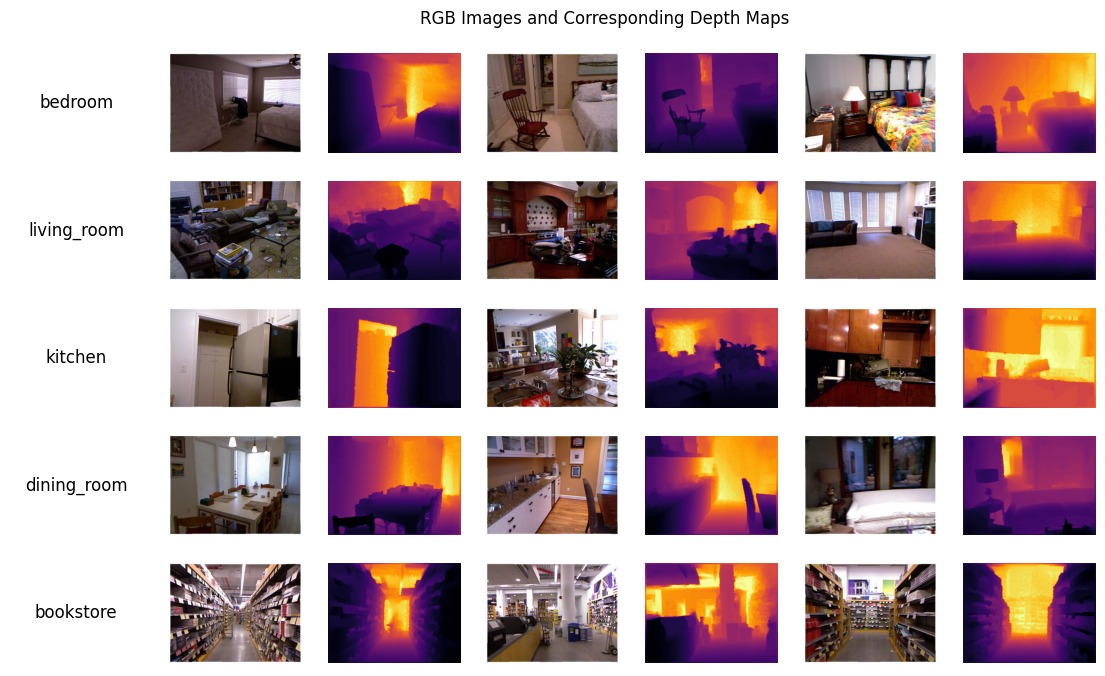

In [ ]:
# Create Subplots
fig, axs = plt.subplots(5, 7, figsize=(14, 8))

# Data
scenes = list(df_metadata_train["scene"].value_counts().keys()[:5])
df_metadata_scene = df_metadata_train[df_metadata_train["scene"]==scenes[0]].reset_index(drop=True)
df_metadata_scene = df_metadata_scene.loc[[0, len(df_metadata_scene)-1], :].reset_index(drop=True)
df_metadata_scene

# Plot
for i, scene in enumerate(scenes):
    # Scene
    axs[i, 0].text(0.5, 0.5, scene, ha='center', va='center', fontsize=12)
    axs[i, 0].axis('off')

    df_metadata_scene = df_metadata_train[df_metadata_train["scene"]==scene].reset_index(drop=True)
    df_metadata_scene = df_metadata_scene.loc[[0, len(df_metadata_scene)//2, len(df_metadata_scene)-1], :].reset_index(drop=True)

    for j in range(3):
        # RGB Image
        rgb_path = "/kaggle/input/nyu-depth-v2/nyu_data/" + df_metadata_scene.loc[j, "rgb"]
        rgb_image = cv2.imread(rgb_path)
        rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
        axs[i, j*2+1].imshow(rgb_image)
        axs[i, j*2+1].axis('off')

        # Depth Image
        depth_path = "/kaggle/input/nyu-depth-v2/nyu_data/" + df_metadata_scene.loc[j, "depth"]
        depth_image = cv2.imread(depth_path)
        depth_image = cv2.cvtColor(depth_image, cv2.COLOR_BGR2GRAY)
        depth_image = np.expand_dims(depth_image, -1)
        axs[i, j*2+2].imshow(depth_image, cmap="inferno")
        axs[i, j*2+2].axis('off')

# Title
plt.suptitle("RGB Images and Corresponding Depth Maps", x=0.55, y=0.93)

# Show
plt.show()

## RGB and corresponding Depth

In [ ]:
def depth_statistics(image_path):
    img = cv2.imread("/kaggle/input/nyu-depth-v2/nyu_data/" + image_path)
    depth_range = img.max() - img.min()
    mean = np.mean(img)
    std = np.std(img)
    return depth_range, mean, std

df_metadata_train["depth_range"], df_metadata_train["mean"], df_metadata_train["std"] = zip(*df_metadata_train['depth'].progress_apply(depth_statistics))
df_metadata_test["depth_range"], df_metadata_test["mean"], df_metadata_test["std"] = zip(*df_metadata_test['depth'].progress_apply(depth_statistics))

display(df_metadata_train)
display(df_metadata_test)

100%|██████████| 654/654 [00:09<00:00, 67.40it/s]


,rgb,depth,scene,depth_range,mean,std
0,data/nyu2_train/living_room_0038_out/37.jpg,data/nyu2_train/living_room_0038_out/37.png,living_room,223,93.306442,50.263732
1,data/nyu2_train/living_room_0038_out/115.jpg,data/nyu2_train/living_room_0038_out/115.png,living_room,97,76.810316,22.220856
2,data/nyu2_train/living_room_0038_out/6.jpg,data/nyu2_train/living_room_0038_out/6.png,living_room,229,100.978893,52.491114
3,data/nyu2_train/living_room_0038_out/49.jpg,data/nyu2_train/living_room_0038_out/49.png,living_room,227,93.152998,51.268261
4,data/nyu2_train/living_room_0038_out/152.jpg,data/nyu2_train/living_room_0038_out/152.png,living_room,176,78.140430,43.172204
...,...,...,...,...,...,...
50683,data/nyu2_train/dining_room_0031_out/441.jpg,data/nyu2_train/dining_room_0031_out/441.png,dining_room,166,105.371042,50.255534
50684,data/nyu2_train/dining_room_0031_out/365.jpg,data/nyu2_train/dining_room_0031_out/365.png,dining_room,154,97.024310,46.218216
50685,data/nyu2_train/dining_room_0031_out/447.jpg,data/nyu2_train/dining_room_0031_out/447.png,dining_room,159,101.325937,48.613924
50686,data/nyu2_train/dining_room_0031_out/90.jpg,data/nyu2_train/dining_room_0031_out/90.png,dining_room,202,97.144268,37.550307


,rgb,depth,depth_range,mean,std
0,data/nyu2_test/00000_colors.png,data/nyu2_test/00000_depth.png,7,10.731589,1.675725
1,data/nyu2_test/00001_colors.png,data/nyu2_test/00001_depth.png,6,6.331501,1.475183
2,data/nyu2_test/00008_colors.png,data/nyu2_test/00008_depth.png,25,8.951709,6.308503
3,data/nyu2_test/00013_colors.png,data/nyu2_test/00013_depth.png,8,9.845566,1.262471
4,data/nyu2_test/00014_colors.png,data/nyu2_test/00014_depth.png,34,12.194176,7.683139
...,...,...,...,...,...
649,data/nyu2_test/01444_colors.png,data/nyu2_test/01444_depth.png,23,10.948910,5.608204
650,data/nyu2_test/01445_colors.png,data/nyu2_test/01445_depth.png,21,12.108630,5.328718
651,data/nyu2_test/01446_colors.png,data/nyu2_test/01446_depth.png,17,9.702350,4.891516
652,data/nyu2_test/01447_colors.png,data/nyu2_test/01447_depth.png,27,12.906738,6.976634


# UNet Model Architecture

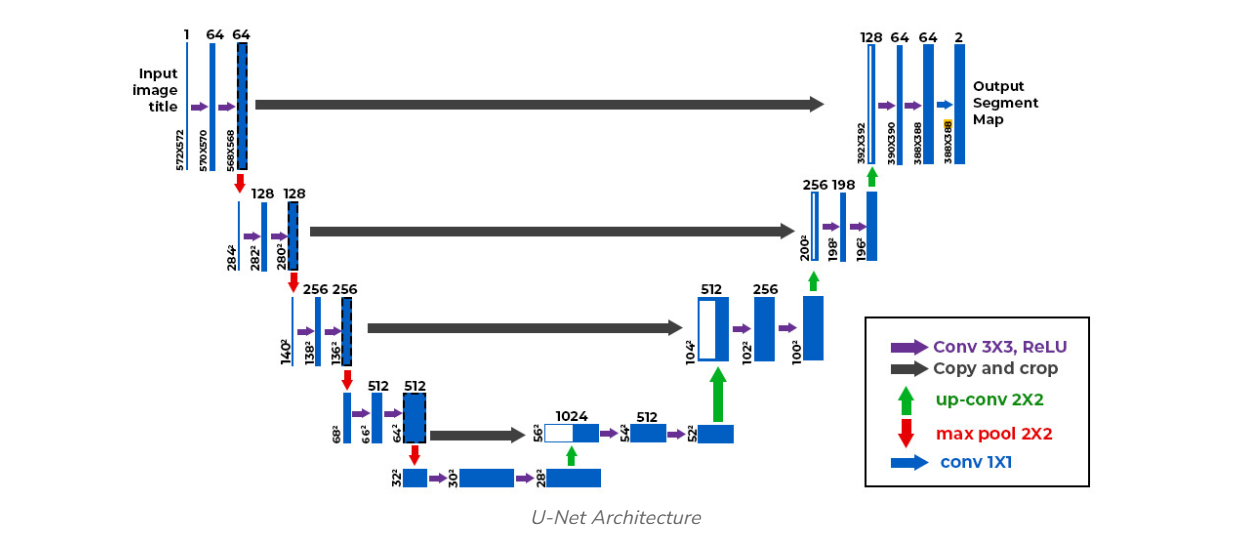

### Imports

In [ ]:
## Imports
import torch.nn as nn
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import os
from torchvision.utils import save_image
import glob
import math
from sklearn.model_selection import train_test_split
import gc
import time
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import cv2

### Unet model

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        #channels: 3->64,
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        #channels: 64->128
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, stride = 1, padding = 1)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        #channels: 128->256
        self.conv5 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1, padding = 1)
        self.conv6 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, stride = 1, padding = 1)
        self.maxpool3 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        #channels: 256->512
        self.conv7 = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 1, padding = 1)
        self.conv8 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1, padding = 1)
        self.maxpool4 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        #channels:512->1024
        self.conv9 = nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size = 3, stride = 1, padding = 1)
        self.conv10 = nn.Conv2d(in_channels = 1024, out_channels = 1024, kernel_size = 3, stride = 1, padding = 1)
        self.upconv1 = nn.ConvTranspose2d(in_channels = 1024, out_channels = 512, kernel_size = 2, stride = 2)
        #channels:1024->512
        self.conv11 = nn.Conv2d(in_channels = 1024, out_channels = 512, kernel_size = 3, stride = 1, padding = 1)
        self.conv12 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1, padding = 1)
        self.upconv2 = nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size = 2, stride = 2)
        #channels: 512->256
        self.conv13 = nn.Conv2d(in_channels = 512, out_channels = 256, kernel_size = 3, stride = 1, padding = 1)
        self.conv14 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, stride = 1, padding = 1)
        self.upconv3 = nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size = 2, stride = 2)
        #channels:256->128
        self.conv15 = nn.Conv2d(in_channels = 256, out_channels = 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv16 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, stride = 1, padding = 1)
        self.upconv4 = nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 2, stride = 2)
        #channels:128->64
        self.conv17 = nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv18 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        #channels:64->1
        self.conv19 = nn.Conv2d(in_channels = 64, out_channels = 1, kernel_size = 1, stride = 1, padding = 0)

        #relu: for non-linearity relu(x)=max(0,x)
        self.relu = nn.ReLU()
        #group_normalisation
        self.gn1 = nn.GroupNorm(16, 64)
        self.gn2 = nn.GroupNorm(16, 128)
        self.gn3 = nn.GroupNorm(16, 256)
        self.gn4 = nn.GroupNorm(16, 512)
        self.gn5 = nn.GroupNorm(16, 1024)
        #drop out layers; set the fraction of neurons to 0
        self.dropout = nn.Dropout(0.5)
        self.dropout1 = nn.Dropout(0.25)

    def forward(self, x):
        x = self.conv1(x)
        x = self.gn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.gn1(x)
        x = self.relu(x)
        out1 = x
        x = self.maxpool1(x)
        x = self.dropout1(x)
        x = self.conv3(x)
        x = self.gn2(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.gn2(x)
        x = self.relu(x)
        out2 = x
        x = self.maxpool2(x)
        x = self.dropout(x)
        x = self.conv5(x)
        x = self.gn3(x)
        x = self.relu(x)
        x = self.conv6(x)
        x = self.gn3(x)
        x = self.relu(x)
        out3 = x
        x = self.maxpool3(x)
        x = self.dropout(x)
        x = self.conv7(x)
        x = self.gn4(x)
        x = self.relu(x)
        x = self.conv8(x)
        x = self.gn4(x)
        x = self.relu(x)
        out4 = x
        x = self.maxpool4(x)
        x = self.dropout(x)
        x = self.conv9(x)
        x = self.gn5(x)
        x = self.relu(x)
        x = self.conv10(x)
        x = self.gn5(x)
        x = self.relu(x)
        x = self.upconv1(x)
        x = torch.cat((x, out4), 1)
        x = self.dropout(x)
        x = self.conv11(x)
        x = self.gn4(x)
        x = self.relu(x)
        x = self.conv12(x)
        x = self.gn4(x)
        x = self.relu(x)
        x = self.upconv2(x)
        x = torch.cat((x, out3), 1)
        x = self.dropout(x)
        x = self.conv13(x)
        x = self.gn3(x)
        x = self.relu(x)
        x = self.conv14(x)
        x = self.gn3(x)
        x = self.relu(x)
        x = self.upconv3(x)
        x = torch.cat((x, out2), 1)
        x = self.dropout(x)
        x = self.conv15(x)
        x = self.gn2(x)
        x = self.relu(x)
        x = self.conv16(x)
        x = self.gn2(x)
        x = self.relu(x)
        x = self.upconv4(x)
        x = torch.cat((x, out1), 1)
        x = self.dropout(x)
        x = self.conv17(x)
        x = self.gn1(x)
        x = self.relu(x)
        x = self.conv18(x)
        x = self.gn1(x)
        x = self.relu(x)
        x = self.conv19(x)
        x = torch.nn.functional.sigmoid(x) #since depth is between 0-1
        return x


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def minmaxscaler(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

### Building a dataset loader

In [ ]:
class NYUDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.transform = transforms.Compose([
                                transforms.Resize((264, 264)),
                                transforms.CenterCrop((256, 256)),
                                transforms.ToTensor(),                # Convert the images to tensors
                                transforms.Normalize(                 # Normalize with ImageNet statistics
                                    mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]
                                ),
                            ])
        self.depthtransform = transforms.Compose([
                                transforms.Resize((264, 264)),
                                transforms.CenterCrop((256, 256)),
                                transforms.ToTensor(),                # Convert the images to tensors
                            ])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        rgb_path = self.dataframe.iloc[idx]['rgb']
        depth_path = self.dataframe.iloc[idx]['depth']

        # Load images
        rgb_image = Image.open("../kaggle/input/nyu-depth-v2/nyu_data/"+rgb_path).convert("RGB")
        depth_image = Image.open("../kaggle/input/nyu-depth-v2/nyu_data/"+ depth_path).convert("L")  # Assuming depth is single-channel

        if self.transform:
            rgb_image = self.transform(rgb_image)
            depth_image = self.depthtransform(depth_image)

        depth_image = (depth_image - torch.min(depth_image)) / (torch.max(depth_image) - torch.min(depth_image))

        return rgb_image, depth_image

In [ ]:
df_small_train = pd.read_csv("df_metadata_train.csv")
df_small_val = pd.read_csv("df_metadata_val.csv")
train_dataset=NYUDataset(dataframe=df_small_train)
val_dataset = NYUDataset(dataframe=df_small_val)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True,num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False,num_workers=2)

In [ ]:
epoch_train_losses = []              # Defining an empty list to store the epoch losses
epoch_val_losses = []

batch_size = 8
epochs = 2
lr = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



def loss_function(y_true, y_pred):
    l_depth = torch.mean(torch.abs(y_pred - y_true))
    l_mse = torch.mean(torch.abs(y_pred - y_true)**2)
    # weightage
    w2, w3 = 1.0, 10.0
    return (w3 * l_depth) + (w2 * l_mse)

In [ ]:
model = UNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9)
best_valid_loss = float('inf')
# check for existing checkpoints
if os.path.isfile("depth_estimation_curr.pt"):
    checkpoint = torch.load('depth_estimation_curr.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    best_valid_loss = checkpoint['loss']
else:
    print("No existing weights found")

No existing weights found


In [ ]:
def train(model, dataset, optimizer, device):

    train_loss_batch = []
    model.train()

    for idx,(images, labels) in enumerate(dataset):
        images = images.to(device)
        labels = labels.to(device)
        #Forward Pass
        output = model(images)
        train_loss = loss_function(labels, output)
        train_loss_batch.append(train_loss)
        # output = torch.round(output)
        if idx % 100 == 0:
            print(f"Batch: {idx + 1}   Train Loss: {train_loss}")
        if idx % 100 == 0:
            one_width = output.shape[3]
            total_width = one_width * 3
            new_image = Image.new('RGB', (total_width, output.shape[2]))
            # Paste the images into the new image
            new_image.paste(Image.fromarray(np.uint8(minmaxscaler(images[0].permute(1, 2, 0).detach().cpu().numpy())*255.)), (0, 0))
            new_image.paste(Image.fromarray(np.uint8(minmaxscaler(labels[0].repeat(3, 1, 1).permute(1, 2, 0).detach().cpu().numpy())*255.)), (one_width, 0))
            new_image.paste(Image.fromarray(np.uint8(minmaxscaler(output[0].repeat(3, 1, 1).permute(1, 2, 0).detach().cpu().numpy())*255.)), (one_width*2, 0))
            new_image.save('combined_image.png')
        # Backward
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
    epoch_train_losses.append(sum(train_loss_batch)/len(dataset))
    print(f"Train Epoch Loss: {sum(train_loss_batch)/len(dataset)}")

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

for epoch in range(epochs):
    start_time = time.monotonic()
    print(f"Epoch: {epoch + 1}")
    train(model, train_loader, optimizer, device)
    torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict()
          }, f'depth_estimation.pt')
    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.empty_cache()
    gc.collect()
    print("\n\n\n TIME TAKEN FOR THE EPOCH: {} mins and {} seconds".format(epoch_mins, epoch_secs))

print("OVERALL TRAINING COMPLETE")

Epoch: 1
Batch: 1   Train Loss: 2.5027761459350586
Batch: 101   Train Loss: 2.670307159423828
Batch: 201   Train Loss: 2.6280860900878906
Batch: 301   Train Loss: 2.309635877609253
Batch: 401   Train Loss: 2.3265442848205566
Batch: 501   Train Loss: 2.052395820617676
Batch: 601   Train Loss: 2.041141986846924
Train Epoch Loss: 2.302863121032715



 TIME TAKEN FOR THE EPOCH: 4 mins and 51 seconds
Epoch: 2
Batch: 1   Train Loss: 1.9032609462738037
Batch: 101   Train Loss: 2.2202608585357666
Batch: 201   Train Loss: 1.9259915351867676
Batch: 301   Train Loss: 1.9975874423980713
Batch: 401   Train Loss: 1.9398493766784668
Batch: 501   Train Loss: 1.6267071962356567
Batch: 601   Train Loss: 2.037287712097168
Train Epoch Loss: 2.008502960205078



 TIME TAKEN FOR THE EPOCH: 4 mins and 50 seconds
Epoch: 3
Batch: 1   Train Loss: 1.7540279626846313
Batch: 101   Train Loss: 1.8447784185409546
Batch: 201   Train Loss: 2.016775131225586
Batch: 301   Train Loss: 2.192157030105591
Batch: 401   Train

In [ ]:
if os.path.isfile("depth_estimation.pt"):
    checkpoint = torch.load('depth_estimation.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    # epoch = checkpoint['epoch']
    # best_valid_loss = checkpoint['loss']

def validate(model, dataset, device):

    train_loss_batch = []
    accu_train_batch = []
    model.eval()
    with torch.no_grad():
        for idx,(images, labels) in enumerate(dataset):
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)

            if idx % 1 == 0:
                one_width = output.shape[3]
                total_width = one_width * 3
                new_image = Image.new('RGB', (total_width, output.shape[2]))

                # Paste the images into the new image
                new_image.paste(Image.fromarray(np.uint8(minmaxscaler(images[0].permute(1, 2, 0).detach().cpu().numpy())*255.)), (0, 0))
                new_image.paste(Image.fromarray(np.uint8(minmaxscaler(labels[0].repeat(3, 1, 1).permute(1, 2, 0).detach().cpu().numpy())*255.)), (one_width, 0))
                new_image.paste(Image.fromarray(np.uint8(minmaxscaler(output[0].repeat(3, 1, 1).permute(1, 2, 0).detach().cpu().numpy())*255.)), (one_width*2, 0))
                new_image.save(f'combined_image{idx+1}.png')

validate(model, val_loader, device)

### Results after 5 epochs

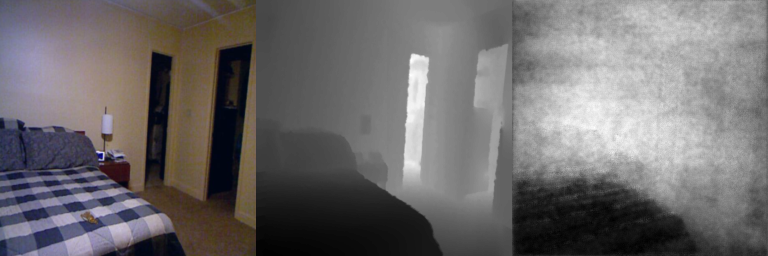

### Results after 250 epochs

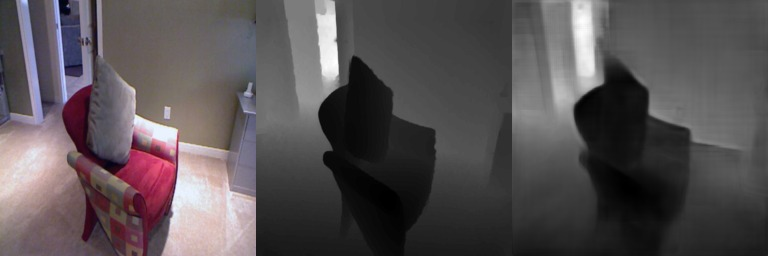

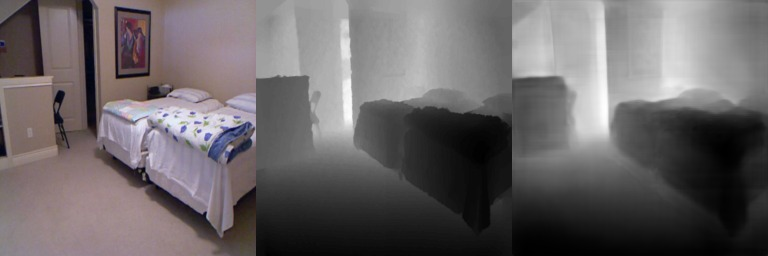

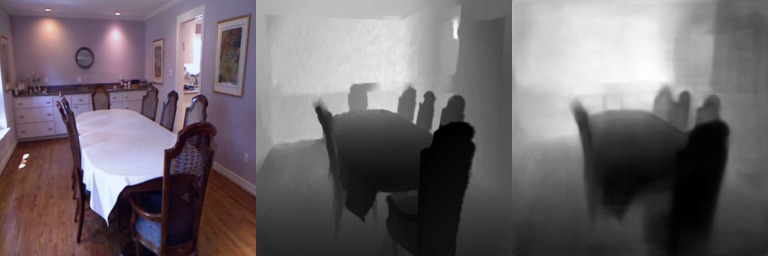